In [1]:
import scipy as sp
from scipy import io
import meshpy.triangle as triangle
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as pt
import math
import scipy.sparse
import scipy.sparse.linalg

We deal with meshes, generated by meshpy and facets --- pairs of points that define boundary. We usually denote the data as mp = points (coordinates of point of the mesh), mt = triangles (triple of numbers of point that are contained in triangle), and mf = faces (pairs of points which are on boundary --- facets)

The function creates a stifness matrix for a single triangle

In [2]:
def stiff_matr_for_triangle(triag, points):
    r1 = points[triag[0]]
    r2 = points[triag[1]]
    r3 = points[triag[2]]
    S_T = 0.5 * abs((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0]))
    
    G = np.ones((3, 3))
    G[1:,0] = r1
    G[1:,1] = r2
    G[1:,2] = r3
    G = np.linalg.solve(G, np.array([[0, 0], [1, 0], [0, 1]]))
    
    M = G.dot(G.T) * S_T/2
    
    return M

Here the right_hand_side $Ax = f$, $f$ can be defined

In [3]:
def right_hand_side(x):
    return 1

The function solves numerical differencial equation on the mesh. Notation is the same --- mp (points), mt (triangles), mf (facets), f --- right_hand_side

In [4]:
def fem_solve(mesh_points, mesh_tris, mesh_facets, f):
    b = np.zeros(mesh_points.shape[0])

    A = sp.sparse.lil_matrix((mesh_points.shape[0], mesh_points.shape[0]))
    for triag in mesh_tris:
        M = stiff_matr_for_triangle(triag, mesh_points)
        for k in range(3):
            for l in range(3):
                A[triag[k], triag[l]] += M[k, l]


    for triag in mesh_tris:
        r1 = mesh_points[triag[0]]
        r2 = mesh_points[triag[1]]
        r3 = mesh_points[triag[2]]
        S_T = abs(0.5 * ((r2[0] - r1[0]) * (r3[1] - r1[1]) - (r2[1] - r1[1]) * (r3[0] - r1[0])))

        for k in range(3):
            b[triag[k]] += 1./3 * S_T*f(mesh_points[triag[k]])
    
    for i in mesh_facets[:, 0]:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1.
        b[i] = 0
        
    for i in mesh_facets[:, 1]:
        A[i, :] = 0
        A[:, i] = 0
        A[i, i] = 1.
        b[i] = 0
    A = sp.sparse.csc_matrix(A)
    sol = sp.sparse.linalg.spsolve(A, b)
        
    return sol

The following function implements computation of gradient on the triangle. Here t is a triangle (triplet of points), points --- points of the mesh, and sol --- mesh function (the solution of our equation) (will be removed)

The function of constructing array of all edges in the mesh. mt --- triangles, mp --- points

In [5]:
def get_edges(mt, mp):
    A_connect1 = np.zeros((len(mp), len(mp)))
    for i in mt:
        A_connect1[i[0], i[1]] = 1
        A_connect1[i[0], i[2]] = 1
        A_connect1[i[1], i[2]] = 1
    A = A_connect1+A_connect1.T
    set_edges = []
    for i in range(A.shape[0]):
        for j in range(i, A.shape[0]):
            if A[i,j] >0:
                set_edges.append([i,j])
    return set_edges

Function that finds adjacent triangles for the array of edges. Here edges is the array that was generated by get_edges function, and mt are the triangles.

In [6]:
def find_triangle_neighbours(edges, mt):
    triangle_neighbours = np.zeros((len(edges),2)) -1
    k = 0
    for i in edges:
        l = 0
        for j in mt:
            edge1 = [j[0], j[1]]
            edge2 = [j[0], j[2]]
            edge3 = [j[1], j[2]]
            if (set(i) == set(edge1)) or (set(i) == set(edge2)) or (set(i) == set(edge3)):
                if triangle_neighbours[k][0]>=0:
                    triangle_neighbours[k][1] = l
                else:
                    triangle_neighbours[k][0] = l
            l = l+1
        k = k+1  
    return triangle_neighbours

Measure of given triangle

In [7]:
def triangle_measure(mp, i):
    mes_tr = abs(0.5*(mp[i[0]][0] - mp[i[2]][0])*(mp[i[1]][1]-mp[i[2]][1])
                      -(mp[i[1]][0] - mp[i[2]][0])*(mp[i[0]][1]-mp[i[2]][1]))
    return mes_tr

Half-Perimeter of a given triangle

In [8]:
def p_triangle(mp, t):
    p = (mp[t[0]][0]**2+mp[t[1]][0]**2 +mp[t[2]][0]**2+mp[t[0]][1]**2+mp[t[1]][1]**2
            + mp[t[2]][1]**2 - 1*(mp[t[0]][0]*mp[t[1]][0]+ mp[t[0]][0]*mp[t[2]][0]+mp[t[1]][0]*mp[t[2]][0]
            + mp[t[0]][1]*mp[t[1]][1]+ mp[t[0]][1]*mp[t[2]][1]+mp[t[1]][1]*mp[t[2]][1]))
    return p

Norm of function f on triangle t.

In [9]:
def norm_f(mp, t, f):
    mes_tr = triangle_measure(mp, t)
    norm = 1.0/3*(f(mp[t[0]]) + f(mp[t[1]]) + f(mp[t[2]]))*mes_tr
    return norm

The following function computes the indicator for each edge, now the simple method of computing indictaor $I[i] = \frac{1}{2}(|T_1|*p_{T_1}+|T_2|*p_{T_2})$, $|T| = mes(T)$, $p_{T_1}$ --- half-perimeter.

This function should be rewritten to add the following contribution:
$$
((\nabla U_{T_1}- \nabla U_{T_2}), \vec n)^2*|e|^2, ~~ \text{where $e$ is the edge}
$$

In [10]:
def compute_indicator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]] # vector joining the two ends of the edge
            n = [-e[1], e[0]] # its normal vector
            n = n / la.norm(n) # scaled
            
            indicator[i] =  (# here the first part of the formula is inserted
                        + 0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                        + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][1])]))**2)))
            
                        
    return indicator          

If where contains what returns True, else False

In [11]:
def if_contains(what, where):
    for i in where:
        if (what == i).all():
            return True
    return False

The most important function --- it refines the given mesh acording to the rule of refinement.

In [12]:
def refine(mp, mt, right_hand_side, sol, part):
    edges = get_edges(mt,mp) #find all edges
    neigh = find_triangle_neighbours(edges, mt) #find what triangles are neighbours
    
    ind = compute_indicator(neigh, edges, mp, mt, sol, right_hand_side) #compute indicator for each edge
    sort_ind = np.sort(ind) 
    
    number_of_new_points = int(math.floor(len(mp)*part)) #find the top part of indicators
    points = list(mp)
    for i in sort_ind[-number_of_new_points:]: #refine mesh
        for j in range(len(ind)):
            if i == ind[j]:
                new_p = (mp[edges[j][0]]+mp[edges[j][1]])/2.0
                if not if_contains(new_p, points):
                    points.append(np.array(new_p))
    return points

Integrate the solution over the domain.

In [13]:
def integrate_over_mesh(mp, mt, sol):
    s = 0
    for i in mt:
        mes_tr = abs(0.5*((mp[i[0]][0] - mp[i[2]][0])*(mp[i[1]][1]-mp[i[2]][1])
                          -(mp[i[1]][0] - mp[i[2]][0])*(mp[i[0]][1]-mp[i[2]][1])))
        s = s + 1.0/3*(sol[i[0]] + sol[i[1]] + sol[i[2]])*mes_tr
        
    return s

## Initial mesh
Here we create a simple mesh on a domain.

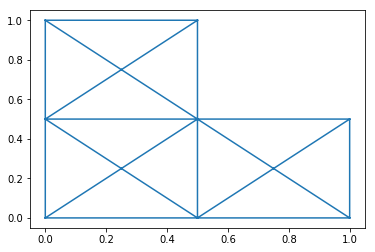

In [14]:
points = [ (0,0),(1,0),(1,0.5),(0.5,0.5),(0.5, 1), (0,1) ] #boundary ponts

def round_trip_connect(start, end):
  result = []
  for i in range(start, end):
    result.append((i, i+1))
  result.append((end, start))
  return result

def needs_refinement(vertices, area ):
    return area > 0.1

#create a mesh
info = triangle.MeshInfo()
info.set_points(points)
info.set_facets(round_trip_connect(0, len(points)-1))

mesh = triangle.build(info, refinement_func=needs_refinement)
#plot and save the mesh
import matplotlib.pyplot as pt
mp = np.array(mesh.points)
mt = np.array(mesh.elements)
mf = np.array(mesh.facets)
pt.triplot(mp[:, 0], mp[:, 1], mt)
pt.show()

## Solve the system 

We solve system on the mesh and plot the solution

C:\Users\HP\Anaconda3\lib\site-packages\scipy\sparse\lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
C:\Users\HP\Anaconda3\lib\site-packages\scipy\sparse\lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
C:\Users\HP\Anaconda3\lib\site-packages\scipy\sparse\lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  


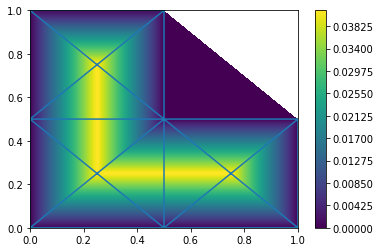

In [15]:
sol = fem_solve(mp, mt, mf, right_hand_side)

%matplotlib inline
import matplotlib.mlab as mlab
pt.triplot(mp[:, 0], mp[:, 1], mt)
xi = np.linspace(0, 1, 100) 
yi = np.linspace(0, 1, 100)
z = mlab.griddata(mp[:, 0], mp[:, 1], sol, xi, yi, interp='linear')
pt.contourf(xi, yi, z, 200)
pt.colorbar()

Process of refinement. N --- number of steps. 

In [16]:
reference_integral = 0.026686473764298849

part = 0.1 # refine 10% of the triangles each time
max_mesh = 500 # approximate maximal number of point in the mesh
sol = fem_solve(mp, mt, mf, right_hand_side)

# we plot the error vs number of nodes in the mesh
plot_n = []
plot_err = []

while len(mp) < max_mesh:
    points = refine(mp, mt, right_hand_side, sol, part)
    info_s = triangle.MeshInfo()
    info_s.set_points(points)
    info_s.set_facets(mf)
    mesh = triangle.build(info_s, min_angle = 30)    
    mp = np.array(mesh.points)
    mt = np.array(mesh.elements)
    mf = np.array(mesh.facets)
    sol = fem_solve(mp, mt, mf, right_hand_side)
    integral_over = integrate_over_mesh(mp, mt, sol)
    plot_n.append(len(mp))
    plot_err.append(abs(integral_over - reference_integral))   

C:\Users\HP\Anaconda3\lib\site-packages\scipy\sparse\lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
C:\Users\HP\Anaconda3\lib\site-packages\scipy\sparse\lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
C:\Users\HP\Anaconda3\lib\site-packages\scipy\sparse\lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


### Plot the graph

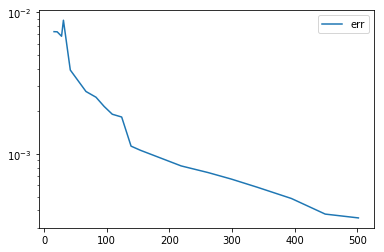

In [17]:
pt.semilogy(plot_n, plot_err, label = 'err')
pt.legend()
pt.show()

## Your solution

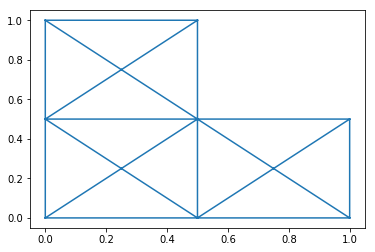

In [18]:
# Initial mesh:
points = [ (0,0),(1,0),(1,0.5),(0.5,0.5),(0.5, 1), (0,1) ] #boundary ponts
info = triangle.MeshInfo()
info.set_points(points)
info.set_facets(round_trip_connect(0, len(points)-1))

mesh = triangle.build(info, refinement_func=needs_refinement)
#plot and save the mesh
import matplotlib.pyplot as pt
mp = np.array(mesh.points)
mt = np.array(mesh.elements)
mf = np.array(mesh.facets)
pt.triplot(mp[:, 0], mp[:, 1], mt)
pt.show()

In [19]:
# TODO: implement The following function implements computation of gradient on the triangle.
# Here t is a triangle (triplet of points), points --- points of the mesh,
# and sol --- mesh function (the solution of our equation)
def compute_grad(t, points, sol):
    grad = np.zeros(2)
    
    # TODO: COMPUTE THE GRADIENT
    
    return grad    

In [20]:
def compute_indicator_good(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / la.norm(n)
            indicator[i] = (0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                        + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][1])]))**2))
                           # TODO: ADD THE GRADIENT JUMP CONTRIBUTION
                           )
            
                        
    return indicator

In [21]:
def refine_good(mp, mt, right_hand_side, sol, part):
    edges = get_edges(mt,mp) #find all edges
    neigh = find_triangle_neighbours(edges, mt) #find wich triangles are neighbours
    
    ind = compute_indicator_good(neigh, edges, mp, mt, sol, right_hand_side) #compute indicator for each edge
    sort_ind = np.sort(ind)
    
    number_of_new_points = int(math.floor(len(mp)*part)) #find the top part of indicators
    points = list(mp)
    for i in sort_ind[-number_of_new_points:]: #refine mesh
        for j in range(len(ind)):
            if i == ind[j]:
                new_p = (mp[edges[j][0]]+mp[edges[j][1]])/2.0
                if not if_contains(new_p, points):
                    points.append(np.array(new_p))
    return points

In [22]:
part = 0.1 # refine 10% of the triangles each time
max_mesh = 500 # approximate maximal number of point in the mesh
sol = fem_solve(mp, mt, mf, right_hand_side)

# we plot the error vs number of nodes in the mesh
plot_n_good = []
plot_err_good = []

while len(mp) < max_mesh:
    points = refine(mp, mt, right_hand_side, sol, part)
    info_s = triangle.MeshInfo()
    info_s.set_points(points)
    info_s.set_facets(mf)
    mesh = triangle.build(info_s, min_angle = 30)    
    mp = np.array(mesh.points)
    mt = np.array(mesh.elements)
    mf = np.array(mesh.facets)
    sol = fem_solve(mp, mt, mf, right_hand_side)
    integral_over = integrate_over_mesh(mp, mt, sol)
    plot_n_good.append(len(mp))
    plot_err_good.append(abs(integral_over - reference_integral))

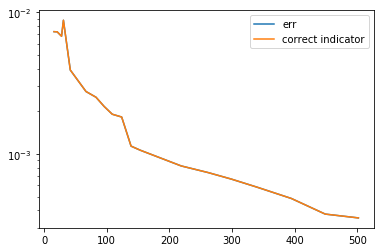

In [23]:
pt.semilogy(plot_n, plot_err, label = 'err')
pt.semilogy(plot_n_good, plot_err_good, label = 'correct indicator')
pt.legend()
pt.show()

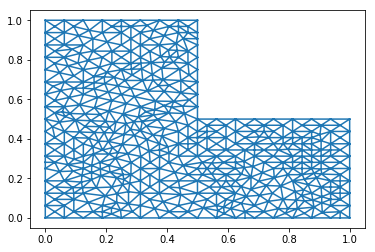

In [24]:
pt.triplot(mp[:, 0], mp[:, 1], mt)

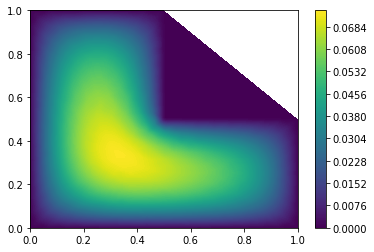

In [25]:
sol = fem_solve(mp, mt, mf, right_hand_side)
xi = np.linspace(0, 1, 100)
yi = np.linspace(0, 1, 100)
z = mlab.griddata(mp[:, 0], mp[:, 1], sol, xi, yi, interp='linear')
pt.contourf(xi, yi, z, 200)
pt.colorbar()